# LDA Topic Modeling

This notebook implements topic modeling using gensim LDA

## Imports

In [30]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import pickle
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import gensim
from gensim import corpora, models
from gensim.models.wrappers import LdaMallet
from gensim.models import CoherenceModel, LdaModel, LdaMulticore
pd.set_option('display.width',-1)


In [31]:
mallet_path = "/Users/sowerre/mallet-2.0.8/bin/mallet"

In [2]:
# run some files containing custom functions
%run -i '../scripts/helper_functions.py'

## Load Data

In [3]:
df = pd.read_csv('../data/all_data.csv')
df.head()

,reviews,rating,company
0,Great card! We get cash back for our grocery a...,4.0,American Express Blue Cash Preferred
1,While traveling we had to keep calling the Cre...,1.0,Credit One Bank
2,Great card to have! Love all the additional cr...,5.0,Capital One Quicksilver Rewards
3,no tengo tanta experiencia asi que no puedo da...,2.0,Citi Double Cash Card
4,This is a basic credit card. The cash back dea...,4.0,Bank of America Cash Rewards Credit Card


In [4]:
df.shape

(25708, 3)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25708 entries, 0 to 25707
Data columns (total 3 columns):
reviews    25708 non-null object
rating     25708 non-null float64
company    25708 non-null object
dtypes: float64(1), object(2)
memory usage: 602.7+ KB


In [6]:
# Drop rows with missing value if any
df = df.dropna().reset_index(drop = True)

In [7]:
# Remove wide space in review texts
df['reviews']  = df['reviews'].apply(detokenizer)
df.to_csv('../data/all_data.csv', index = False) # save as csv file

In [8]:
#Display the index row
print_review(df, index =25247)

Review: Great experience with American Express. Their customer service is outstanding, and they are invariably pleasant to deal with - including a next-day ship on a misplaced card. The cashback is another great feature!
Rating: 5.0
Credit card: American Express Blue Cash Preferred 


In [9]:
# reload the data
df =pd.read_csv('../data/all_data.csv') 

In [10]:
review_count = df.groupby('company')['reviews'].count().sort_values(ascending = False)
review_count.head()

company
Bank of America Cash Rewards Credit Card    2476
Capital One Quicksilver Rewards             2292
Capital One Venture Rewards                 2204
Capital One Platinum                        2103
Credit One Bank                             2016
Name: reviews, dtype: int64

In [11]:
len(review_count)

40

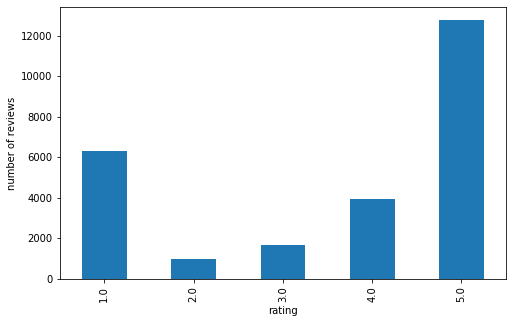

In [12]:
df.groupby('rating')['reviews'].count().plot(kind = 'bar', figsize = (8,5))
plt.ylabel('number of reviews')
plt.savefig('../image/rating.png')

# Data Pre-processing
- Document cleaning
- Tokenization
- Lemmatization
- Stopwords removal
- Bag of words
- Topic modeling with LDA

In [13]:
# text preprocessing
df = pre_process_text(df, 'reviews') 

In [14]:
# tokenization
df['tokens'] =  df['reviews'].apply(my_tokenizer)

In [15]:
def word_count(text):
    """Plot the most frequency words in the corpus"""
    all_reviews = ' '.join(text) # join all reviews
    token_count = Counter(my_tokenizer(all_reviews)) # count each word
    common_words =  dict( token_count.most_common(n=25) ) # count most common 20 words
    freq_plot = pd.Series(common_words, index=None).plot(kind = 'bar', figsize=(12,8))
    plt.ylabel('count')
    plt.savefig('../figures/fig2.pdf')

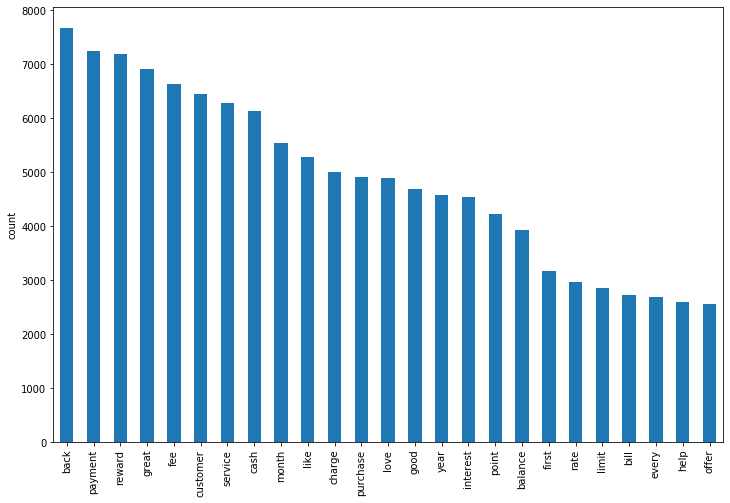

In [16]:
word_count(df.reviews)

## Bigrams and Trigrams

In [17]:
df['bigram_tokens'] = add_bigram(df.tokens)
df['trigram_tokens'] = add_trigram(df.tokens)
df.head()

,reviews,rating,company,tokens,bigram_tokens,trigram_tokens
0,great card! we get cash back for our grocery a...,4.0,American Express Blue Cash Preferred,"[great, cash, back, grocery, gas, purchase, fo...","[great, cash_back, grocery_gas, purchase, food...","[great, cash_back, grocery_gas, purchase, food..."
1,while traveling we had to keep calling the cre...,1.0,Credit One Bank,"[travel, keep, customer, service, lock, transa...","[travel, keep, customer_service, lock, transac...","[travel, keep, customer_service, lock, transac..."
2,great card to have! love all the additional cr...,5.0,Capital One Quicksilver Rewards,"[great, love, additional, rating, check, feature]","[great, love, additional, rating, check, feature]","[great, love, additional, rating, check, feature]"
3,no tengo tanta experiencia asi que no puedo da...,2.0,Citi Double Cash Card,"[tengo, tanta, experiencia, asi, que, puedo, d...","[tengo, tanta, experiencia, asi, que, puedo, d...","[tengo, tanta, experiencia, asi, que, puedo, d..."
4,this is a basic credit card the cash back dea...,4.0,Bank of America Cash Rewards Credit Card,"[basic, cash, back, deal, nice, cash, year, an...","[basic, cash_back, deal, nice, cash, year, ann...","[basic, cash_back, deal, nice, cash, year, ann..."


In [18]:
# Create a dictornary, i.e associate each unique token with unique integer ID
dictionary = corpora.Dictionary(df.trigram_tokens)
print(dictionary)

# Bag of words (document-term matrix)
corpus = [dictionary.doc2bow(text) for text in df.trigram_tokens]
print('Number of documents: %s'%len(corpus))

Dictionary(14427 unique tokens: ['apr_little_high', 'balance_full', 'cash_back', 'food_gas', 'fully']...)
Number of documents: 25708


In [19]:
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Topic modeling with LDA

In [20]:
model_list, topic_coherence = compute_coherence_lda(corpus, dictionary, start=2, limit=40, step=6)

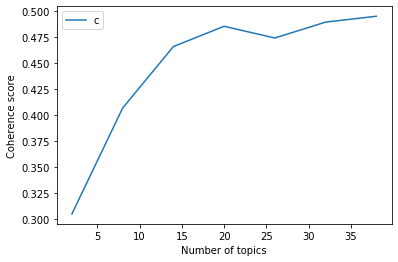

In [21]:
# Plot
num_topics = range(2, 40, 6)
plt.plot(num_topics, topic_coherence)
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.savefig('../figures/topic_coherence.png')

In [22]:
# Print the coherence scores
for top, cv in zip(num_topics, topic_coherence):
    print("{} topics  have coherence score of {}".format(top, round(cv, 4)))

2 topics  have coherence score of 0.3053
8 topics  have coherence score of 0.4071
14 topics  have coherence score of 0.4662
20 topics  have coherence score of 0.4858
26 topics  have coherence score of 0.4745
32 topics  have coherence score of 0.4898
38 topics  have coherence score of 0.4954


In [40]:
optimal_lda = model_list[6]

In [41]:
optimal_lda.show_topics(num_topics=11, num_words=10)

[(37,
  '0.043*"pre_approval" + 0.033*"aspire" + 0.020*"slick" + 0.010*"compatible" + 0.007*"truliant" + 0.007*"ineligible" + 0.007*"inc" + 0.006*"become_eligible" + 0.006*"hsbc" + 0.006*"funding"'),
 (36,
  '0.025*"short_term" + 0.015*"weight" + 0.014*"technician" + 0.012*"sync" + 0.011*"invaluable" + 0.009*"forfeit" + 0.007*"dare" + 0.006*"bat" + 0.005*"fluctuates" + 0.005*"vous"'),
 (35,
  '0.013*"premier_agent" + 0.010*"simulator" + 0.009*"utterly" + 0.007*"susie" + 0.004*"loophole" + 0.004*"fingerhut" + 0.003*"seam" + 0.002*"paraphrase" + 0.002*"herein" + 0.002*"hindsight"'),
 (34,
  '0.031*"limitation" + 0.022*"limited" + 0.017*"water" + 0.014*"visual" + 0.010*"cable" + 0.010*"wear" + 0.010*"strip" + 0.008*"ink" + 0.008*"tear" + 0.008*"bam"'),
 (33,
  '0.023*"necesaria" + 0.013*"tenido_problema" + 0.013*"con_esta_tarjeta" + 0.013*"pida" + 0.013*"emergencia" + 0.013*"cualquier" + 0.012*"muy" + 0.012*"ayuda" + 0.012*"perfecta" + 0.008*"excellente"'),
 (5,
  '0.235*"happy" + 0.036*"

In [38]:
import pyLDAvis.gensim

In [39]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(optimal_lda, corpus, dictionary,sort_topics=False)

/Users/sowerre/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x  \
topic             
0      0.282587   
1      0.449785   
2      0.024258   
3      0.395258   
4      0.224219   
5      0.057881   
6     -0.053726   
7      0.217016   
8      0.066528   
9      0.036146   
10    -0.070031   
11    -0.052162   
12    -0.065178   
13    -0.069747   
14    -0.058069   
15    -0.071820   
16    -0.068325   
17    -0.070683   
18     0.033043   
19    -0.068001   
20    -0.070416   
21     0.021421   
22    -0.071735   
23    -0.067659   
24    -0.069529   
25    -0.069881   
26    -0.072254   
27    -0.056666   
28    -0.059826   
29    -0.068729   
30    -0.071343   
31    -0.067437   
32    -0.063655   
33    -0.070094   
34    -0.070638   
35    -0.068662   
36    -0.070776   
37    -0.071100   

              y  \
topic             
0     -0.207551   
1     -0.017255   
2      0.158838   
3     -0.131190   
4      0.271752   
5      0.066320   
6      0.006814   
7      0.043414   
8      0.036855   
9     -0.009702   
10    -0.021320   
11    -0.015051   
12    -0.016192   
13    -0.021924   
14    -0.007596   
15    -0.020644   
16    -0.021382   
17    -0.024336   
18     0.248664   
19    -0.016610   
20    -0.024396   
21    -0.022411   
22    -0.020974   
23    -0.020159   
24    -0.020016   
25    -0.021695   
26     0.000133   
27     0.030804   
28    -0.016424   
29    -0.020590   
30    -0.021643   
31    -0.017138   
32    -0.020269   
33    -0.011260   
34    -0.023806   
35    -0.025021   
36    -0.023710   
37    -0.023328   

       topics  \
topic           
0           1   
1           2   
2           3   
3           4   
4           5   
5           6   
6           7   
7           8   
8           9   
9          10   
10         11   
11         12   
12         13   
13         14   
14         15   
15         16   
16         17   
17         18   
18         19   
19         20   
20         21   
21         22   
22         23   
23         24   
24         25   
25         26   
26         27   
27         28   
28         29   
29         30   
30         31   
31         32   
32         33   
33         34   
34         35   
35         36   
36         37   
37         38   

       cluster  \
topic            
0            1   
1            1   
2            1   
3            1   
4            1   
5            1   
6            1   
7            1   
8            1   
9            1   
10           1   
11           1   
12           1   
13           1   
14           1   
15           1   
16           1   
17           1   
18           1   
19           1   
20           1   
21           1   
22           1   
23           1   
24           1   
25           1   
26           1   
27           1   
28           1   
29           1   
30           1   
31           1   
32           1   
33           1   
34           1   
35           1   
36           1   
37           1   

            Freq  
topic             
0      51.646019  
1       4.686612  
2       0.574068  
3      34.342491  
4       1.121613  
5       0.572472  
6       0.308237  
7       1.165313  
8       0.529075  
9       0.482382  
10      0.200736  
11      0.254157  
12      0.194778  
13      0.178655  
14      0.236457  
15      0.153539  
16      0.158290  
17      0.130151  
18      0.614108  
19      0.160508  
20      0.118715  
21      0.295016  
22      0.130415  
23      0.145633  
24      0.134334  
25      0.124201  
26      0.129447  
27      0.144359  
28      0.146151  
29      0.125067  
30      0.109994  
31      0.137052  
32      0.120236  
33      0.082807  
34      0.098091  
35      0.066380  
36      0.090781  
37      0.091663  , topic_info=     Category  \
28    Default   
5     Default   
70    Default   
205   Default   
48    Default   
...       ...   
2248  Topic38   
4908  Topic38   
5458  Topic38   
5057  Topic38   
266   Topic38   

             Freq  \
28    5037.000000   
5     6608.000000   
70   